Using device: mps
MPS backend enabled for M4 GPU acceleration


/var/folders/df/89kgtpnn77vc6rkbbypgww8m0000gn/T/ipykernel_10952/2828260833.py:197: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Final Train Loss: 0.790992, Train Acc: 0.692533, Test Acc: 0.694100


TypeError: Invalid shape (1, 224, 224) for image data

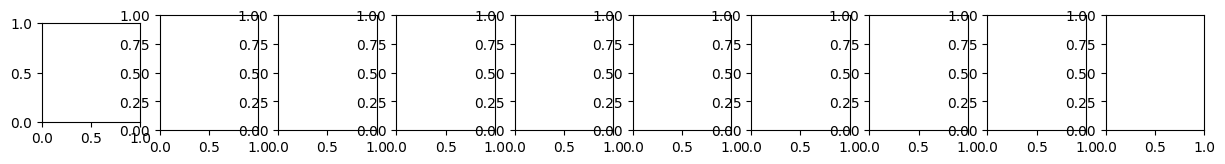

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.cuda.amp import autocast, GradScaler

# 设置随机种子
torch.manual_seed(42)

# 1. 检查 MPS 可用性并设置设备
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'mps':
    print("MPS backend enabled for M4 GPU acceleration")
else:
    print("Warning: MPS not available, falling back to CPU")

# 2. 数据加载：Fashion-MNIST
def load_data_fashion_mnist(batch_size, resize=None):
    transform_list = [transforms.ToTensor()]
    if resize:
        transform_list.insert(0, transforms.Resize(resize))
    transform = transforms.Compose(transform_list)
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, test_loader

# 3. 辅助函数
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        for i, arg in enumerate(args):
            if isinstance(arg, (int, float)):
                self.data[i] += arg
            else:
                raise ValueError(f"Expected numeric value, got {type(arg)}")
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    _, preds = torch.max(y_hat, 1)
    return (preds == y).sum().item()

def evaluate_accuracy(net, data_iter, device):
    net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


    
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.cpu().numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.'), nrows=1, ncols=1,
                 figsize=(10, 6)):
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes]
        self.xlabel, self.ylabel = xlabel, ylabel
        self.xlim, self.ylim = xlim, ylim
        self.xscale, self.yscale = xscale, yscale
        self.legend = legend
        self.fmts = fmts
        self.X, self.Y = None, None
    
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.axes[0].set_xlabel(self.xlabel)
        self.axes[0].set_ylabel(self.ylabel)
        self.axes[0].set_xlim(self.xlim)
        self.axes[0].set_ylim(self.ylim)
        self.axes[0].set_xscale(self.xscale)
        self.axes[0].set_yscale(self.yscale)
        if self.legend:
            self.axes[0].legend(self.legend)
        self.axes[0].grid()
        plt.savefig("training_progress.png")
        plt.close()

        
        
# 4. AlexNet 模型（添加 torch.cat 示例）
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
        # 初始化权重（类似 RNN 的 torch.normal）
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, aux_input=None):
        x = self.features(x)
        x = self.classifier(x)
        if aux_input is not None:  # Example: Concatenate auxiliary input (e.g., sensor data)
            aux_input = aux_input.to(x.device)
            x = torch.cat((x, aux_input), dim=1)  # Requires matching dimensions
            x = nn.Linear(x.shape[1], self.classifier[-1].out_features)(x)
        return x

# 5. 训练函数
def train_epoch(net, train_iter, loss_fn, optimizer, device, scaler):
    metric = Accumulator(3)
    net.train()
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        try:
            y_hat = net(X.to(device))
            loss = loss_fn(y_hat, y.to(device))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        except RuntimeError as e:
            print(f"MPS error: {e}. Falling back to CPU for this batch.")
            X, y = X.to('cpu'), y.to('cpu')
            net.to('cpu')
            optimizer.zero_grad()
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
            net.to(device)
        with torch.no_grad():
            metric.add(loss.item() * X.shape[0], accuracy(y_hat, y), X.shape[0])
    return metric[0] / metric[2], metric[1] / metric[2]

def train(net, train_iter, test_iter, loss_fn, num_epochs, lr, device):
    optimizer = optim.SGD(net.parameters(), lr=lr)
    scaler = GradScaler()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                       legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss_fn, optimizer, device, scaler)
        test_acc = evaluate_accuracy(net, test_iter, device)
        animator.add(epoch + 1, (train_loss, train_acc, test_acc))
    print(f"Final Train Loss: {train_loss:.6f}, Train Acc: {train_acc:.6f}, Test Acc: {test_acc:.6f}")

# 6. 预测函数
def predict(net, test_iter, device, n=10):
    net.eval()
    with torch.no_grad():
        for X, y in test_iter:
            X, y = X.to(device), y.to(device)
            break
        trues = get_fashion_mnist_labels(y)
        preds = get_fashion_mnist_labels(net(X).argmax(dim=1))
        titles = [f"{true}\n{pred}" for true, pred in zip(trues, preds)]
        show_images(X.cpu()[:n], 1, n, titles=titles[:n])
    
# 7. 运行训练和预测
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
net = AlexNet().to(device)
loss_fn = nn.CrossEntropyLoss()
train(net, train_iter, test_iter, loss_fn, num_epochs=10, lr=0.01, device=device)
predict(net, test_iter, device)